## Import

In [47]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import xgboost as xgb 
from xgboost import XGBClassifier
import numpy as np

import joblib
import sys
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve, auc
import matplotlib.pyplot as plt

project_root = Path.cwd().parent 
sys.path.insert(0, str(project_root))

# Now imports work
from config import RAW_DATA_PATH, MODEL_PARAMS, BASE_DIR
from src.features import preprocess_features 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load and Prepare

In [49]:
# Load a sample for speed (Kartik dataset is 1.8M rows)
# 500k is enough to get 0.99 AUC without killing your RAM
df = pd.read_csv(RAW_DATA_PATH, nrows=500000)


## Split 

In [50]:
# Split raw data
train_raw, test_raw = train_test_split(
    df, 
    test_size=0.2, 
    stratify=df['is_fraud'], 
    random_state=42
)

In [51]:
# Preprocess features
X_train = preprocess_features(train_raw)
y_train = train_raw['is_fraud']

X_test = preprocess_features(test_raw)
y_test = test_raw['is_fraud']

## Train

In [52]:
model = xgb.XGBClassifier(
      **MODEL_PARAMS
)

In [53]:
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=50
)

[0]	validation_0-aucpr:0.73704


c:\Users\hp\Fraud\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [18:32:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[50]	validation_0-aucpr:0.88277
[100]	validation_0-aucpr:0.89970
[150]	validation_0-aucpr:0.91030
[200]	validation_0-aucpr:0.91856
[250]	validation_0-aucpr:0.92468
[300]	validation_0-aucpr:0.92824
[350]	validation_0-aucpr:0.93156
[400]	validation_0-aucpr:0.93322
[450]	validation_0-aucpr:0.93499
[499]	validation_0-aucpr:0.93587


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,True
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

## Find optimal threshold

In [54]:
# 1. Get probabilities
probs = model.predict_proba(X_test)[:, 1]

# 2. Calculate Precision-Recall pairs
precision, recall, thresholds = precision_recall_curve(y_test, probs)

# 3. Calculate F1 for every threshold
# F1 = 2 * (p * r) / (p + r)
f1_scores = (2 * precision * recall) / (precision + recall + 1e-10)

# 4. Get the threshold that corresponds to the highest F1 score
# Note: thresholds has one less element than precision/recall, so we use its length
best_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[best_idx]

print(f"Optimal Threshold: {optimal_threshold:.6f}")
print(f"Max F1-Score: {f1_scores[best_idx]:.4f}")

Optimal Threshold: 0.522147
Max F1-Score: 0.8739


## Evaluate

In [55]:
probs = model.predict_proba(X_test)[:, 1]
preds = (probs >= 0.5221).astype(int)

print(f"\n{'='*50}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, probs):.4f}")
print(f"\n{'='*50}")

print(classification_report(y_test, preds, digits=4))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, preds))



ROC-AUC Score: 0.9987

              precision    recall  f1-score   support

           0     0.9988    0.9998    0.9993     99392
           1     0.9661    0.7977    0.8739       608

    accuracy                         0.9986    100000
   macro avg     0.9824    0.8988    0.9366    100000
weighted avg     0.9986    0.9986    0.9985    100000


Confusion Matrix:
[[99375    17]
 [  123   485]]


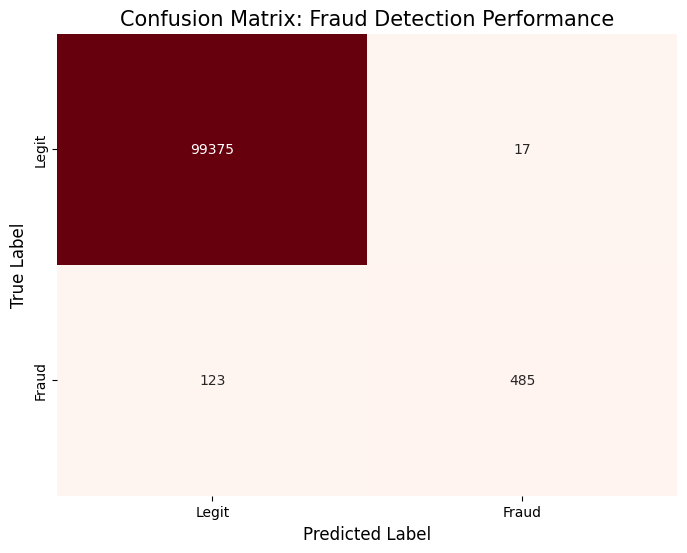

In [ ]:

cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False,
            xticklabels=['Legit', 'Fraud'], 
            yticklabels=['Legit', 'Fraud'])

plt.title('Confusion Matrix: Fraud Detection Performance', fontsize=15)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

In [57]:
importance = model.feature_importances_

feat_importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importance
}).sort_values("importance", ascending=False)

feat_importance.head(30)


,feature,importance
7,category,0.313597
0,amt,0.299049
4,hour,0.216108
3,age,0.049406
8,gender,0.046308
9,state,0.029623
1,city_pop,0.019650
5,day_of_week,0.015680
2,dist_to_merchant,0.010580
6,is_weekend,0.000000


<Figure size 1000x800 with 0 Axes>

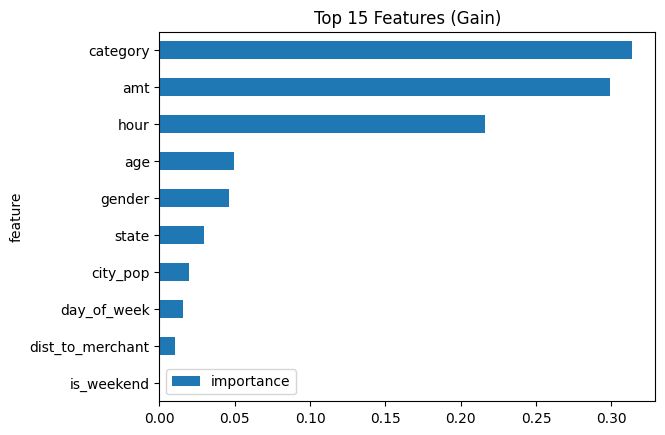

In [43]:

plt.figure(figsize=(10, 8))
feat_importance.head(15).plot(kind='barh', x='feature', y='importance')
plt.gca().invert_yaxis()
plt.title("Top 15 Features (Gain)")
plt.show()

## Save Model


In [46]:

model.save_model(BASE_DIR / "model" / "fraud_model.json")

# Saving feature list is crucial for FastAPI endpoint
joblib.dump(list(X_train.columns), BASE_DIR / "model" / "feature_list.pkl")

['C:\\Users\\hp\\Fraud\\model\\feature_list.pkl']